# Reconstruction from interpolated values with known locations

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.interpolate import *
from src.algorithm import conjugate_gradient
import jax
from src.utils import mip_z

Create the grids and the volume

In [3]:
nx = 5

x_freq = jnp.fft.fftfreq(nx, 1/nx)
y_freq = x_freq
z_freq = x_freq

X, Y, Z = jnp.meshgrid(x_freq, y_freq, z_freq)


x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

vol = jnp.array(np.random.randn(nx,nx,nx)) + jnp.array(np.random.randn(nx,nx,nx))*1j + 100+80j

all_coords = jnp.array([X.ravel(), Y.ravel(), Z.ravel()])

Generate points on or off the grid

In [4]:
N = 2000

# The points will be on the grid between low and high. 
# Going outside the range by half, to ensure wrap-around works well.
low = -3*nx
high = 3*nx

# Actually not going outside the range for now
#low = -nx/2
#high = nx/2

#pts = jnp.array(np.random.randint(low, high, size = (3,N))).astype(jnp.float64)

# Points between grid points
pts = 3*nx * np.random.randn(3,N)


In [5]:
@jax.jit
def interpolate_fun(vol):
    return interpolate(pts, x_grid, y_grid, z_grid, vol, "tri")

The interpolated values, i.e. the data. When the points above are on the grid, this is the volume.

In [6]:
data = interpolate_fun(vol)

In [8]:
@jax.jit
def loss_fun(v):
    err = interpolate_fun(v) - data
    return 1/(2*len(data))*jnp.sum(jnp.real(jnp.conj(err)*err))

@jax.jit
def loss_fun_grad(v):
    return jax.grad(loss_fun)(v)

In [11]:
loss_fun(vol)

DeviceArray(0., dtype=float64)

In [12]:
loss_fun_grad(vol).shape

(5, 5, 5)

### Solve the inverse problem

#### SGD

In [22]:
v0 = jnp.array(np.random.randn(nx,nx,nx)) + jnp.array(np.random.randn(nx,nx,nx))*1j
#v0 = vol + 0.1*np.random.randn(nx,nx,nx)

vk = v0
N_iter = 2000
alpha = 100
for k in range(N_iter):
    vk = vk - alpha * jnp.conj(loss_fun_grad(vk))
    
    if jnp.mod(k,100) == 0:
        loss = loss_fun(vk)
        print("iter ", k, ", loss = ", loss)

err = jnp.max(jnp.abs(vk-vol))
print("err =", err)

iter  0 , loss =  314.7679602772746
iter  100 , loss =  0.00019694009587457582
iter  200 , loss =  2.0152007947747508e-07
iter  300 , loss =  2.2577935105533995e-10
iter  400 , loss =  2.592881156889917e-13
iter  500 , loss =  3.0157680144558036e-16
iter  600 , loss =  3.542227417207517e-19
iter  700 , loss =  4.1974234858738084e-22
iter  800 , loss =  5.0237227189049085e-25
iter  900 , loss =  1.1769047399428484e-27
iter  1000 , loss =  8.617642746379168e-28
iter  1100 , loss =  8.617642746379168e-28
iter  1200 , loss =  8.617642746379168e-28
iter  1300 , loss =  8.617642746379168e-28
iter  1400 , loss =  8.617642746379168e-28
iter  1500 , loss =  8.617642746379168e-28
iter  1600 , loss =  8.617642746379168e-28
iter  1700 , loss =  8.617642746379168e-28
iter  1800 , loss =  8.617642746379168e-28
iter  1900 , loss =  8.617642746379168e-28
err = 4.522982653395373e-13


In [26]:
jnp.max(jnp.abs(vk-vol))

DeviceArray(4.52298265e-13, dtype=float64)

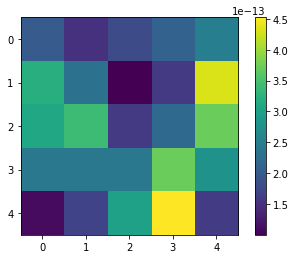

In [27]:
mip_z(jnp.abs(vk-vol));plt.colorbar()

#### CG

In [36]:
v0 = jnp.array(np.random.randn(nx,nx,nx)) + jnp.array(np.random.randn(nx,nx,nx))*1j
zero = jnp.zeros(vol.shape)*1j
Ab = -jnp.conj(loss_fun_grad(zero))
AA = lambda a : jnp.conj(loss_fun_grad(a)) + Ab


vcg, max_iter = conjugate_gradient(AA, Ab, v0, 50, verbose = True)
err = jnp.max(jnp.abs(vcg-vol))
print("err =", err)

Iter 0 ||r|| = 0.5698062707021639
Iter 1 ||r|| = 0.18310864763767531
Iter 2 ||r|| = 0.0896684358163932
Iter 3 ||r|| = 0.039946712708897464
Iter 4 ||r|| = 0.022928671800307554
Iter 5 ||r|| = 0.015468351087390746
Iter 6 ||r|| = 0.010411966515997777
Iter 7 ||r|| = 0.007131844211264982
Iter 8 ||r|| = 0.004853952371654473
Iter 9 ||r|| = 0.0035673516389445044
Iter 10 ||r|| = 0.002188045203168941
Iter 11 ||r|| = 0.0012465028047148597
Iter 12 ||r|| = 0.0008043538796336914
Iter 13 ||r|| = 0.0005053102106779466
Iter 14 ||r|| = 0.00034687207845322956
Iter 15 ||r|| = 0.0001880475058018934
Iter 16 ||r|| = 0.00011522517905692395
Iter 17 ||r|| = 7.67973919984355e-05
Iter 18 ||r|| = 4.836054970537206e-05
Iter 19 ||r|| = 2.712545147063945e-05
Iter 20 ||r|| = 1.7267500600051157e-05
Iter 21 ||r|| = 9.313985337254037e-06
Iter 22 ||r|| = 6.0807603837240965e-06
Iter 23 ||r|| = 3.469537062886576e-06
Iter 24 ||r|| = 2.4367155372888842e-06
Iter 25 ||r|| = 1.5840197318649666e-06
Iter 26 ||r|| = 9.99240973814888

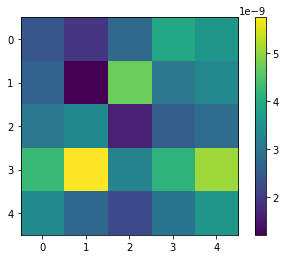

In [37]:
mip_z(jnp.abs(vcg-vol));plt.colorbar()